## Описание задачи:
Необходимо проанализировать поведение студентов на курсах, предметах и экзаменах онлайн-школы.

### Описание данных:
1. Assessments.csv - информация об оценках в тесте.
* code_module - идентификационный код предмета.
* code_presentation — идентификационный код семестра.
* id_assessment — идентификационный номер ассессмента.
* assessment_type — тип теста. (оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam)).
* date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0.
* weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%. Сумма всех остальных оценок составляет 100%.
2. Сourses.csv — информация о предметах по семестрам.
* code_module — идентификационный код предмета.
* code_presentation - идентификационный код семестра.
* module_presentation_length — продолжительность семестра в днях.
3. StudentAssessment.csv — информация о результатах тестов студентов.
* id_assessment — идентификационный номер теста.
* id_student — идентификационный номер студента.
* date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.
* is_banked — факт перезачета теста с прошлого семестра.
* score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.
4.  StudentRegistration.csv — информация о времени, когда студент зарегистрировался для прохождения курса в семестре.
* code_module - идентификационный код предмета.
* code_presentation - идентификационный код семестра.
* id_student - идентификационный номер студента.
* date_registration - дата регистрации студента. Это количество дней, измеренное от начала семестра. (отрицательное значение -30  => студент зарегистрировался на прохождение курса за 30 дней до его начала).
* date_unregistration -  дата отмены регистрации студента с предмета.

### Ход исследования:

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def download_yandex_disk_files(public_keys, file_names):
    """
    Функция для скачивания публичных файлов из яндекс диска
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    for i in range(len(public_keys)):
        # получаем ссылку для скачивания
        final_url = base_url + urlencode(dict(public_key=public_keys[i]))
        response = requests.get(final_url)
        download_url = response.json()['href']
        
        # скачиваем файл
        download_response = requests.get(download_url)
        with open(file_names[i], 'wb') as f:
            f.write(download_response.content)
        print(f"Файл {file_names[i]} успешно скачан!")

In [3]:
public_keys = [
    'https://disk.yandex.ru/d/WG2u0PPEfUCWvw',
    'https://disk.yandex.ru/d/51xrZHoHNy3R3Q',
    'https://disk.yandex.ru/d/eCCGfl52Xp_4Lw',
    'https://disk.yandex.ru/d/H_qZLNN9wgnAwQ'
]

file_names = [
    'assessments.csv',
    'courses.csv',
    'studentAssessment.csv',
    'studentRegistration.csv'
]

In [4]:
# скачиваем файлы
download_yandex_disk_files(public_keys, file_names)

Файл assessments.csv успешно скачан!
Файл courses.csv успешно скачан!
Файл studentAssessment.csv успешно скачан!
Файл studentRegistration.csv успешно скачан!


##### Посмотрим сколько студентов успешно сдали только один курс

In [5]:
# данные об оценках в тесте
assessments = pd.read_csv('assessments.csv')
# данные о результатах тестов студентов
student_assessment = pd.read_csv('studentAssessment.csv')
# данные о времени, когда студент зарегистрировался для прохождения курса
student_registration = pd.read_csv('studentRegistration.csv')
# данные о курсах
courses = pd.read_csv('courses.csv')

In [6]:
# объединяем данные об оценках в тесте и результатах тестов студентов
merge_as_st_as = assessments.merge(student_assessment, how='inner', on='id_assessment')
# фильтруем данные по успешному экзамену
exam_score = merge_as_st_as.loc[(merge_as_st_as['assessment_type'] == 'Exam') & (merge_as_st_as['score'] > 39)]
# считаем студентов, которые сдали только 1 курс
count_student_sucess_exam = len(exam_score.groupby('id_student', as_index=False)\
                                .agg({'id_assessment':'count'}).query('id_assessment==1'))
print(f'Количество студентов, сдавших один курс: {count_student_sucess_exam}')

Количество студентов, сдавших один курс: 3802


##### Выведем курсы по возрастанию уровня завершаемости*
*завершаемость = кол-во успешных экзаменов/кол-во всех попыток сдать экзамен * 100.

In [7]:
# датасет об оценках и о результатах тестов только экзаменов
exam_df = merge_as_st_as.loc[merge_as_st_as['assessment_type']=='Exam']

# суммарное количество попыток сдать экзамен
course_exam_try = exam_df.groupby('id_assessment', as_index=False)\
                         .agg({'assessment_type':'count'})\
                         .rename(columns={'assessment_type':'sum_exam_try'})
# количество успешно сданных экзаменов
exam_sucess = exam_score.groupby('id_assessment', as_index=False)\
                            .agg({'assessment_type':'count'})\
                            .rename(columns={'assessment_type':'sucess_exam_try'})
# объединенный датафрейм
exam_df_success_and_no = course_exam_try.merge(exam_sucess, how='inner', on='id_assessment')

# уровень завершенности
exam_df_success_and_no['level_end'] = exam_df_success_and_no['sucess_exam_try'] / exam_df_success_and_no['sum_exam_try'] * 100

# сортировка для курсов
exam_df_success_and_no = exam_df_success_and_no.sort_values(by='level_end')

# итог
exam_df_success_and_no

,id_assessment,sum_exam_try,sucess_exam_try,level_end
2,25340,602,504,83.720930
1,24299,1168,1019,87.243151
5,25368,950,842,88.631579
0,24290,747,664,88.888889
3,25354,968,878,90.702479
4,25361,524,485,92.557252


##### Самые популярные предметы (ТОП-3) по количеству регистраций на них

In [8]:
student_registration.groupby('code_module', as_index=False)\
                    .agg({'id_student':'count'})\
                    .rename(columns={'id_student':'cnt_registration'})\
                    .sort_values(by='cnt_registration', ascending=False)\
                    .head(3)

,code_module,cnt_registration
1,BBB,7909
5,FFF,7762
3,DDD,6272


##### Предметы с самым большим оттоком* (ТОП-3)
*Отток в данном случае — это отмена регистрации на предмет.

In [9]:
# данные только о тех регистрациях, которые отменились
ottok_student = student_registration.loc[~student_registration['date_unregistration'].isnull()]

In [10]:
ottok_student.groupby('code_module', as_index=False)\
             .agg({'date_unregistration':'count'})\
             .rename(columns={'date_unregistration':'cnt_student'})\
             .sort_values(by='cnt_student', ascending=False)\
             .head(3)

,code_module,cnt_student
5,FFF,2380
1,BBB,2377
3,DDD,2235


##### Семестр с самой низкой завершаемостью курсов

In [11]:
# информация о попытках сдать экзамен в течение семестра
count_exam_try_in_semestr = merge_as_st_as.groupby('code_presentation', as_index=False)\
                                          .agg({'id_assessment':'count'})\
                                          .rename(columns={'id_assessment':'sum_cnt_try'})

In [12]:
# информация об успешных попытках сдать экзамен в течение семестра
count_exam_try_in_semestr_suc = exam_score.groupby('code_presentation', as_index=False)\
                                          .agg({'id_assessment':'count'})\
                                          .rename(columns={'id_assessment':'cnt_try_suc'})

In [13]:
# объединенный датафрейм о семестре
sem_exam_level = count_exam_try_in_semestr_suc.merge(count_exam_try_in_semestr, how='inner', on='code_presentation')

# уровень завершенности в рамках семестра
sem_exam_level['level_end'] = sem_exam_level['cnt_try_suc'] / sem_exam_level['sum_cnt_try'] * 100

# семестр с самой низкой завершаемостью курсов
sem_min_level = sem_exam_level[sem_exam_level['level_end'] == sem_exam_level['level_end']\
                               .min()]['code_presentation'].iloc[0]
print(f'Семестр с самой низкой завершаемостью курсов: {sem_min_level}')

Семестр с самой низкой завершаемостью курсов: 2013B


##### Семестр с самыми долгими средними сроками сдачи курсов

In [14]:
exam_score.groupby('code_presentation', as_index=False)\
          .agg({'date_submitted':'mean'})\
          .rename(columns={'date_submitted':'mean_period'})\
          .sort_values(by='mean_period', ascending=False)\
          .head(1)

,code_presentation,mean_period
3,2014J,243.680279


### RMF-сегментация

R — среднее время сдачи одного экзамена,

F — завершаемость курсов,

M — среднее количество баллов, получаемое за экзамен.

In [15]:
# данные по recency
df_rec = exam_df.groupby(['id_student'], as_index=False)\
                   .agg({'date_submitted':'mean'})\
                   .rename(columns={'date_submitted':'recency'})

In [16]:
df_rec['recency'].min()  # минимальная граница по recency

np.float64(229.0)

In [17]:
df_rec['recency'].max()  # максимальная граница по recency

np.float64(285.0)

In [18]:
# данные по monetary
df_mon = exam_df.groupby('id_student', as_index=False)\
                       .agg({'score':'mean'})\
                       .rename(columns={'score':'monetary'})

In [19]:
df_mon.monetary.min()  # минимальная граница по monetary

np.float64(0.0)

In [20]:
df_mon.monetary.max()  # максимальная граница по monetary

np.float64(100.0)

In [21]:
# количество попыток сдать экзамен для каждого студента
student_sum_exam = exam_df.groupby('id_student', as_index=False).agg({'id_assessment':'count'})\
                          .rename(columns={'id_assessment':'cnt_exam'})

In [22]:
# количество успешных попыток сдать экзамен для каждого студента
cnt_student_success_exam = exam_score.groupby('id_student', as_index=False).agg({'id_assessment':'count'})\
                                     .rename(columns={'id_assessment':'success_exam'})

In [23]:
# frequency
df_freq = student_sum_exam.merge(cnt_student_success_exam, how='left', on='id_student').fillna(0)

In [24]:
df_freq['frequency']= df_freq['success_exam'] / df_freq['cnt_exam'] * 100

In [25]:
# оставляем нужные столбцы
df_freq_need_col = df_freq[['id_student', 'frequency']]

RFM-сегментация

In [26]:
# объединяем данные (recency, monetary, frequency)
df_rmf = pd.concat([df_rec, df_mon, df_freq_need_col], axis=1)

In [27]:
df_rmf = df_rmf[['recency', 'monetary', 'frequency']]

In [28]:
# выставление шкалы по monetary
df_rmf['M'] = df_rmf.monetary.apply(lambda x: 1 if x < 40 else\
                      (2 if x <= 80 else 3))

# выставление шкалы по recency
median_recency = df_rmf['recency'].median() # медиана recency
df_rmf['R'] = df_rmf.recency.apply(lambda x: 2 if x <= median_recency else 1)

# шкала для frequency
df_rmf['F'] = df_rmf.frequency.apply(lambda x: 1 if x < 50 else\
                        (2 if x < 100 else 3))

In [29]:
df_rmf['RFM'] = df_rmf['R'].astype(str) + df_rmf['F'].astype(str) + df_rmf['M'].astype(str)

1 - худшее значение, 3 - лучшее. Из совокупности трех показателей с одинаковыми оценками складывается сегмент:
- R1—F1—M(1-3) — потерянные
- R1—F(2-3)—M(1-3) — лояльные студенты, потерявшие активность
- R2-F(1-2)-M(1-3) — спящие
- R2-F3-M(1-3) — лояльные спящие студенты
- R3—F1—M(1-3) — новички
- R3—F2—M(1-3) — развивающиеся
- R3—F3—M3 — постоянные

In [30]:
# присвоение сегмента
df_rmf['segment'] = 'другие'
df_rmf.loc[(df_rmf['R'] == 1) & (df_rmf['F'] == 1), 'Segment'] = 'потерянные'
df_rmf.loc[(df_rmf['R'] == 1) & (df_rmf['F'].isin([2,3])), 'Segment'] = 'лояльные, потерявшие активность'
df_rmf.loc[(df_rmf['R'] == 2) & (df_rmf['F'].isin([1,2])), 'Segment'] = 'спящие'
df_rmf.loc[(df_rmf['R'] == 2) & (df_rmf['F'] == 3), 'Segment'] = 'лояльные спящие'
df_rmf.loc[(df_rmf['R'] == 3) & (df_rmf['F'] == 1), 'Segment'] = 'новички'
df_rmf.loc[(df_rmf['R'] == 3) & (df_rmf['F'] == 2), 'Segment'] = 'развивающиеся'
df_rmf.loc[(df_rmf['R'] == 3) & (df_rmf['F'] == 3) & (df_rmf['M'] == 3), 'Segment'] = 'постоянные'

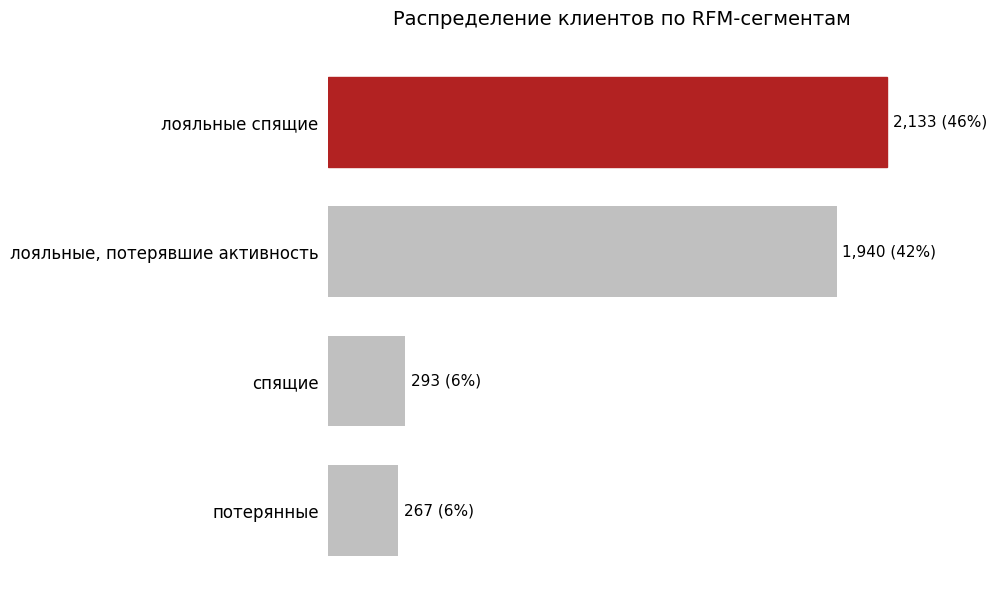

In [31]:
# подсчет количества клиентов в каждом сегменте
segments_counts = df_rmf['Segment'].value_counts().sort_values(ascending=True)

# график
fig, ax = plt.subplots(figsize=(10, 6))

important_segments = ['постоянные', 'развивающиеся', 'лояльные спящие'] 

# рисуем горизонтальные столбцы
bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver',
              height=0.7)  

# оформление графика
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index, fontsize=12)


for i, bar in enumerate(bars):
    value = bar.get_width()
    if segments_counts.index[i] in important_segments:
        bar.set_color('firebrick')
    ax.text(value + segments_counts.max()*0.01,  
            bar.get_y() + bar.get_height()/2,
            '{:,} ({:.0f}%)'.format(int(value), value*100/segments_counts.sum()),
            va='center',
            ha='left',
            fontsize=11)

plt.title('Распределение клиентов по RFM-сегментам', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

1. Лояльные спящие (46%) — 2133 студента:
- Студенты совершали платежи ранее, но сейчас перестали.
- Это студенты, которые, скорее всего, прошли несколько курсов, но не записались на новые.
- Их можно попробовать вернуть, предложив скидки или персонализированные предложения.

2. Лояльные, потерявшие активность (42%) — 1940 студентов:
- Это студенты, которые были активными и приносили хороший доход, но их недавняя активность снизилась.
- Это важный сегмент, так как они уже доверяют школе и, возможно, готовы вернуться при правильной мотивации (например, курс продолжения, вебинары, напоминания о возможностях развития).

3. Спящие (6%) — 293 студента:
- Они когда-то совершали покупки, но в малом количестве.
- Скорее всего, это те, кто попробовал обучение, но не продолжил.
- Можно предложить им пробные уроки, бесплатные материалы или персональные рекомендации.

4. Потерянные (6%) — 267 студентов:
- Это пользователи, которые давно не совершали оплат и, вероятно, больше не вернутся.
- Их сложно реанимировать, но можно протестировать автоматизированные рассылки с предложением вернуться.

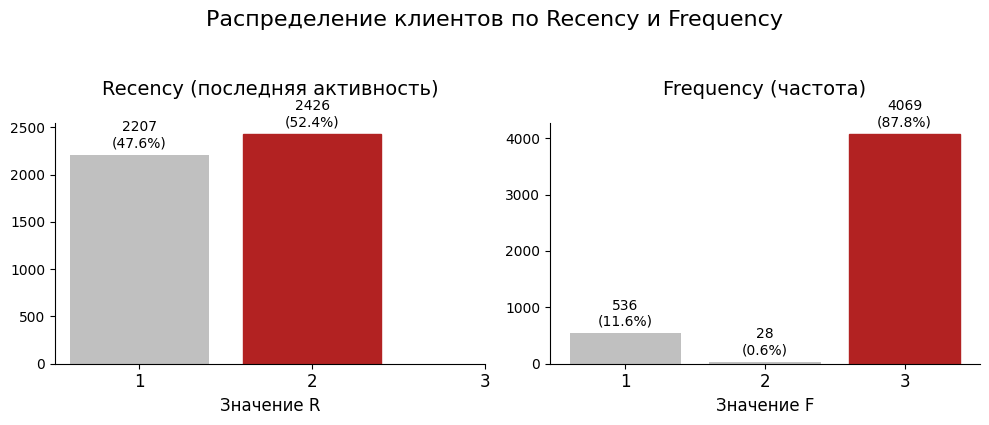

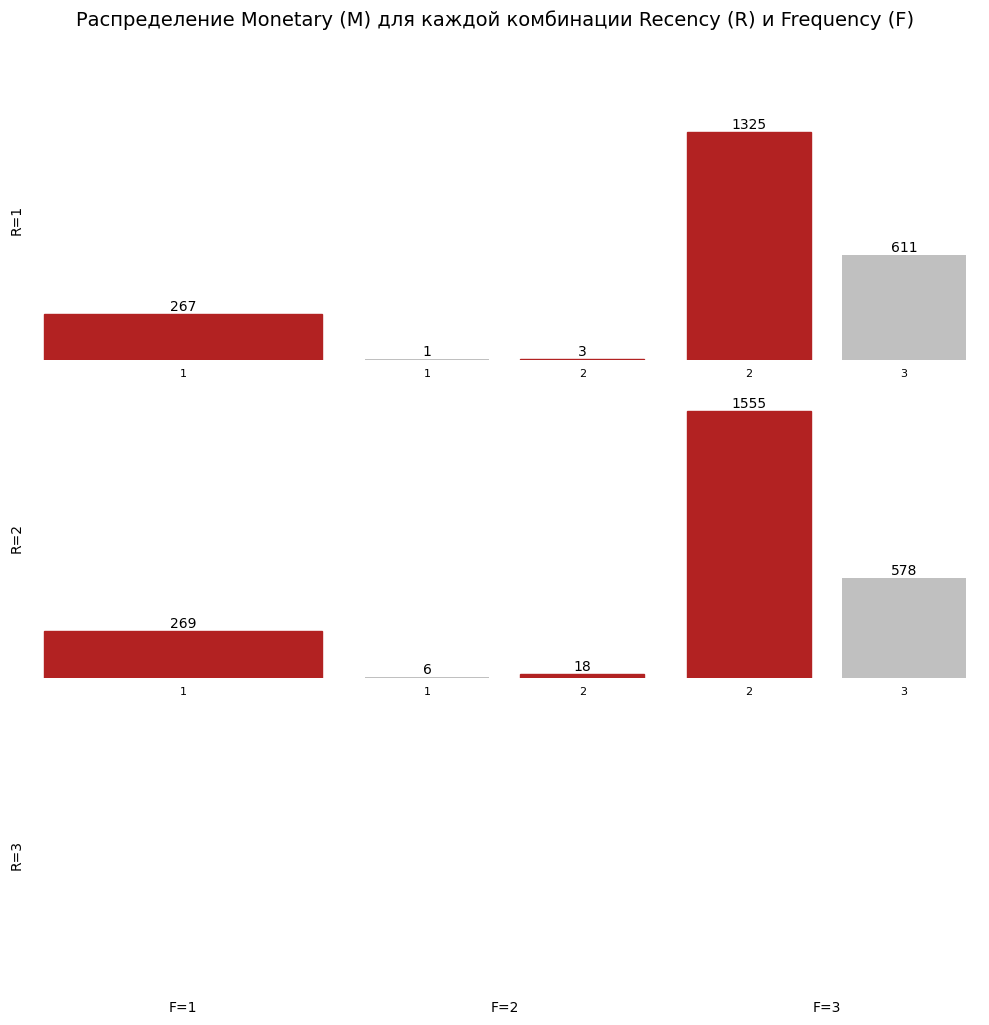

In [32]:
# 1. распределение клиентов по R и F 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R': 'Recency (последняя активность)', 
                 'F': 'Frequency (частота)'}
    y = df_rmf[p].value_counts().sort_index()
    x = y.index
    
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')  
    
    # Настройка осей
    ax.set_xlabel('Значение ' + p, fontsize=12)
    ax.set_xticks([1, 2, 3])  
    ax.set_xticklabels(['1', '2', '3'], fontsize=12)
    
    # включаем только левую ось Y
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    
    ax.tick_params(axis='y', left=True, labelleft=True) 
    
    ax.set_title(parameters[p], fontsize=14, pad=20)
    
    # аннотации на столбцах
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')  
        ax.text(bar.get_x() + bar.get_width() / 2,
                value + max(y)*0.02,  
                f'{value}\n({value/y.sum():.1%})',
                ha='center',
                va='bottom',
                color='black',
                fontsize=10)

plt.suptitle('Распределение клиентов по Recency и Frequency', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# 2. распределение M для каждой комбинации R и F 
fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)  
f_range = range(1, 4)  

for r in r_range:
    for f in f_range:
        y = df_rmf[(df_rmf['R'] == r) & (df_rmf['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        
        # Подписи осей
        if r == 3:  # Последняя строка
            ax.set_xlabel('F={}'.format(f), va='top')
        if f == 1:  # Первая колонка
            ax.set_ylabel('R={}'.format(r))
            
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max() and not pd.isna(value):
                bar.set_color('firebrick')
            if value > 0:  
                ax.text(bar.get_x() + bar.get_width() / 2,
                        value,
                        int(value),
                        ha='center',
                        va='bottom',
                        color='k')

fig.suptitle('Распределение Monetary (M) для каждой комбинации Recency (R) и Frequency (F)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Студенты с F=1 (разовая покупка):
- Большинство из них платиили небольшие суммы (возможно это те, кто купил 1 курс или прошли пробное обучение).
- Их низкий вклад в выручку означает, что они либо не возвращаются, либо не переходят на более дорогие программы.

Студенты с F=2 (повторные покупки):
- Если их R=1|2 (недавний платеж), то они приносят максимальную выручку (~1325–1555).
- Но если R=3 (давно не платили), их вклад в выручку резко падает.

Студенты с F=3 (лояльные клиенты):
- Они стабильно приносят деньги (~578–611), даже если R=2.
- Это говорит о сформированной привычке к обучению.

### Выводы
1. Основной доход приносят студенты с F=2, но есть риск их потери. Нужно удерживать их, предлагая скидки, персональные рекомендации или бонусы.
2. Группа с F=1 требует анализа: если это пробные пользователи, стоит включать их в ретаргетинг и предлагать продолжение.
3. Лояльные студенты (F=3) стабильны, но их можно поощрять программами лояльности, чтобы увеличить их денежный вклад.
4. Почти 90% студентов (лояльные спящие + потерявшие активность) — это потенциально возвратные клиенты (можно запустить email-кампании с персонализированными предложениями; использовать ретаргетинг в соцсетях и тд)